### Transfer from .xml to .json

In [1]:
import xml.etree.ElementTree as ET
import json
import os

def cvat_xml_to_coco_keypoints(xml_path, output_json_path, image_dir):
    # Парсинг XML-файла
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Инициализация структуры COCO Keypoints
    coco_data = {
        "licenses": [{"name": "", "id": 0, "url": ""}],
        "info": {"contributor": "", "date_created": "", "description": "", "url": "", "version": "", "year": ""},
        "categories": [
            {"id": 1, "name": "wings", "supercategory": "", "keypoints": [], "skeleton": []},
            {"id": 2, "name": "head", "supercategory": "", "keypoints": [], "skeleton": []},
            {"id": 3, "name": "abdomen", "supercategory": "", "keypoints": [], "skeleton": []}
        ],
        "images": [],
        "annotations": []
    }
    
    # Маппинг меток CVAT в ID категорий COCO
    label_to_category = {
        "wings": 1,
        "head": 2,
        "abdomen": 3
    }
    
    image_id = 0
    annotation_id = 0
    
    # Обработка каждого изображения в XML
    for image in root.findall('image'):
        image_id += 1
        image_name = image.get('name')
        width = int(image.get('width'))
        height = int(image.get('height'))
        
        # Добавление изображения в COCO
        coco_data['images'].append({
            "id": image_id,
            "width": width,
            "height": height,
            "file_name": image_name,
            "license": 0,
            "flickr_url": "",
            "coco_url": "",
            "date_captured": 0
        })
        
        # Обработка аннотаций точек для текущего изображения
        keypoints = []
        for points in image.findall('points'):
            label = points.get('label')
            if label in label_to_category:
                category_id = label_to_category[label]
                point_str = points.get('points')
                if point_str:  # Проверка, что строка не пустая
                    # Разделяем точки по ";"
                    point_pairs = point_str.split(';')
                    for pair in point_pairs:
                        if pair.strip():  # Проверка, что пара не пустая
                            x, y = map(float, pair.strip().split(','))  # Разделяем x и y по запятой
                            keypoints.extend([x, y, 1])  # Добавляем x, y, видимость (1 для видимой точки)
        
        if keypoints:  # Если есть аннотации для изображения
            annotation_id += 1
            # Вычисляем примерный bounding box (можно улучшить, если нужно)
            min_x = min([k for i, k in enumerate(keypoints) if i % 3 == 0])
            max_x = max([k for i, k in enumerate(keypoints) if i % 3 == 0])
            min_y = min([k for i, k in enumerate(keypoints) if i % 3 == 1])
            max_y = max([k for i, k in enumerate(keypoints) if i % 3 == 1])
            
            bbox = [min_x, min_y, max_x - min_x, max_y - min_y]
            area = bbox[2] * bbox[3] if bbox[2] > 0 and bbox[3] > 0 else 0
            
            coco_data['annotations'].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,  # Используем category_id для каждой аннотации
                "keypoints": keypoints,
                "num_keypoints": len(keypoints) // 3,
                "bbox": bbox,
                "area": area,
                "iscrowd": 0
            })
    
    # Сохранение в JSON
    with open(output_json_path, 'w') as f:
        json.dump(coco_data, f, indent=4)
    
    print(f"Преобразованный файл COCO Keypoints 1.0 сохранен как {output_json_path}")

# Пример использования
xml_path = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations.xml"
output_json_path = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations_200_coco_keypoints.json"
image_dir = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\imgs"  # Директория с изображениями, если нужно проверить их наличие

cvat_xml_to_coco_keypoints(xml_path, output_json_path, image_dir)

Преобразованный файл COCO Keypoints 1.0 сохранен как C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations_200_coco_keypoints.json


### Merge .json files

In [2]:
import json
import os

def merge_coco_files(coco_file1, coco_file2, output_file):
    # Чтение первого COCO файла
    with open(coco_file1, 'r') as f:
        coco1 = json.load(f)
    
    # Чтение второго COCO файла
    with open(coco_file2, 'r') as f:
        coco2 = json.load(f)
    
    # Инициализация объединенного COCO файла
    merged_coco = {
        "licenses": coco1["licenses"],
        "info": coco1["info"],
        "categories": [],
        "images": [],
        "annotations": []
    }
    
    # Объединение категорий (categories) — проверка уникальности по name
    category_name_to_id = {}
    for cat in coco1["categories"]:
        category_name_to_id[cat["name"]] = cat["id"]
        merged_coco["categories"].append(cat)
    
    for cat in coco2["categories"]:
        if cat["name"] not in category_name_to_id:
            new_id = max(category_name_to_id.values(), default=0) + 1
            cat["id"] = new_id
            category_name_to_id[cat["name"]] = new_id
            merged_coco["categories"].append(cat)
        else:
            # Если категория уже существует, используем существующий ID
            cat["id"] = category_name_to_id[cat["name"]]
    
    # Объединение изображений (images) — проверка уникальности по file_name
    image_file_to_id = {img["file_name"]: img["id"] for img in coco1["images"]}
    current_image_id = max(image_file_to_id.values(), default=0)
    
    for img in coco1["images"]:
        merged_coco["images"].append(img)
    
    for img in coco2["images"]:
        if img["file_name"] not in image_file_to_id:
            current_image_id += 1
            img["id"] = current_image_id
            image_file_to_id[img["file_name"]] = current_image_id
            merged_coco["images"].append(img)
        else:
            # Если изображение уже существует, используем существующий ID
            img["id"] = image_file_to_id[img["file_name"]]
    
    # Объединение аннотаций (annotations) — проверка уникальности по id и обновление image_id
    annotation_id_map = {ann["id"]: ann for ann in coco1["annotations"]}
    current_annotation_id = max(annotation_id_map.keys(), default=0)
    
    for ann in coco1["annotations"]:
        merged_coco["annotations"].append(ann)
    
    for ann in coco2["annotations"]:
        if ann["id"] not in annotation_id_map:
            current_annotation_id += 1
            ann["id"] = current_annotation_id
            # Обновляем image_id, если изображение было перенумеровано
            if ann["image_id"] in image_file_to_id:
                ann["image_id"] = image_file_to_id[ann["image_id"]]
            merged_coco["annotations"].append(ann)
        else:
            # Если аннотация уже существует, используем существующий ID
            ann["id"] = annotation_id_map[ann["id"]]
            if ann["image_id"] in image_file_to_id:
                ann["image_id"] = image_file_to_id[ann["image_id"]]
    
    # Сохранение объединенного файла
    with open(output_file, 'w') as f:
        json.dump(merged_coco, f, indent=4)
    
    print(f"Объединенный COCO файл сохранен как {output_file}")

# Пример использования
coco_file1 = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\merged.json"
coco_file2 = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations_200_coco_keypoints.json"
output_file = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\merged_new.json"

merge_coco_files(coco_file1, coco_file2, output_file)

Объединенный COCO файл сохранен как C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\merged_new.json


### Training

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import json
import numpy as np
from PIL import Image
import os

# Загрузка предобученной модели ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Добавление слоев для классификации
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# Изменение выходного слоя для 4 точек (12 значений)
predictions = Dense(4 * 3, activation='linear')(x)  # 4 точки по 3 координаты (x, y, visibility)
outputs = Dense(12, activation='sigmoid')(x)  # 4 точки × 3 координаты

model = Model(inputs=base_model.input, outputs=outputs)

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mse',  # Используем среднеквадратичную ошибку для регрессии координат
              metrics=['mae'])

# Загрузка данных из COCO Keypoints JSON
def load_data(coco_file_path, image_dir):
    with open(coco_file_path, 'r') as f:
        coco_data = json.load(f)

    for ann in coco_data['annotations']:
        ann['bbox'][0] /= coco_data['images'][ann['image_id']]['width']
        ann['bbox'][1] /= coco_data['images'][ann['image_id']]['height']
        ann['bbox'][2] /= coco_data['images'][ann['image_id']]['width']
        ann['bbox'][3] /= coco_data['images'][ann['image_id']]['height']

    
    def generator():
        for image_info in coco_data['images']:
            image_id = image_info['id']
            image_path = os.path.join(image_dir, image_info['file_name'])
        
            # Загрузка изображения
            if os.path.exists(image_path):
                img = Image.open(image_path).convert('RGB')
                img = img.resize((224, 224))  # Пример размера, подходящего для ResNet50
                img_array = np.array(img) / 255.0  # Нормализация
                
                # Поиск аннотаций для данного изображения
                annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
                
                # Подготовка меток (4 точки по 3 координаты)
                keypoints = []
                if annotations:  # Проверка, есть ли аннотации
                    for ann in annotations:
                        # Предположим, что ключевые точки идут в порядке:
                        # [left_wing_x, left_wing_y, left_wing_vis, right_wing_x, right_wing_y, right_wing_vis,
                        #  head_x, head_y, head_vis, abdomen_x, abdomen_y, abdomen_vis]
                        keypoints = [
                            ann['keypoints'][0],  # left_wing_x
                            ann['keypoints'][1],  # left_wing_y
                            ann['keypoints'][2],  # left_wing_vis
                            ann['keypoints'][3],  # right_wing_x
                            ann['keypoints'][4],  # right_wing_y
                            ann['keypoints'][5],  # right_wing_vis
                            ann['keypoints'][6],  # head_x
                            ann['keypoints'][7],  # head_y
                            ann['keypoints'][8],  # head_vis
                            ann['keypoints'][9],  # abdomen_x
                            ann['keypoints'][10],  # abdomen_y
                            ann['keypoints'][11],  # abdomen_vis
                        ]
                else:
                    # Если нет аннотаций, заполняем нулями
                    keypoints = [0] * 12  # 4 точки × 3 координаты
                
                yield img_array, np.array(keypoints)
            else:
                print(f"Image not found: {image_path}")
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),  # Изображение
            tf.TensorSpec(shape=(12,), dtype=tf.float32)  # 4 точки × 3 координаты
        )
    )

# Предположим, что путь к вашему JSON и директории с изображениями
coco_file_path = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\merged_new.json"
image_dir = r'C:\Users\prol-\Documents\Masters\Thesis\analysis\imgs'

# Создание генераторов данных
train_dataset = load_data(coco_file_path, image_dir).batch(32).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = load_data(coco_file_path, image_dir).batch(32).repeat().prefetch(tf.data.AUTOTUNE)

for img, keypoints in train_dataset.take(1):
    print("Keypoints shape:", keypoints.shape)  # Должно быть (12,)
    print("Keypoints:", keypoints)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=4,  # Установите количество шагов на эпоху
    validation_steps=4   # Аналогично для валидации
)

# Сохранение модели
model.save('bee_parts_detection_model_new.keras')

Keypoints shape: (32, 12)
Keypoints: tf.Tensor(
[[25.45 25.69  1.   43.65 81.24  1.   73.1   9.65  1.   59.93 10.61  1.  ]
 [16.59 32.16  1.   33.59 84.59  1.   73.1  21.38  1.   33.59  1.51  1.  ]
 [42.    1.03  1.   81.74 25.21  1.   30.98 81.24  1.   23.8  22.58  1.  ]
 [20.27 21.02  1.   35.9  47.7   1.    6.51 31.44  1.   23.6  72.71  1.  ]
 [ 4.01 33.11  1.   40.9  48.33  1.   19.85 21.44  1.   24.02 73.55  1.  ]
 [21.19 76.93  1.   71.23 29.04  1.   40.82  1.27  1.   19.99 26.17  1.  ]
 [20.48 19.14  1.   17.56 66.46  1.   73.84 23.1   1.   72.8  16.22  1.  ]
 [14.08 72.92  1.   13.45 22.89  1.   71.19 24.14  1.   30.75  1.22  1.  ]
 [74.48 42.95  1.    4.01 48.32  1.   29.69 37.87  1.   33.27 94.9   1.  ]
 [28.94 95.2   1.   70.45 44.14  1.    0.57 49.22  1.   27.15 38.17  1.  ]
 [30.07 27.61  1.   31.03 82.92  1.   76.29 23.06  1.    2.06 26.41  1.  ]
 [ 1.53 38.86  1.   81.03 34.79  1.   38.89 30.72  1.   42.48 83.88  1.  ]
 [42.45 81.48  1.   66.88 18.75  1.   26.65 16.59  1

### Prediction

Минимум и максимум значений в img_array: 0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Сырые предсказания модели: [[0.9739551  0.9608891  0.50668126 0.96927655 0.99404824 0.62068063
  0.9511109  0.93801767 0.16301975 0.9836015  0.9848419  0.35160023]]
Крылья (нормализованные): [0.9739551  0.9608891  0.50668126]
Голова (нормализованные): [0.96927655 0.99404824 0.62068063]
Брюшко (нормализованные): [0.9511109  0.93801767 0.16301975 0.9836015  0.9848419  0.35160023]
Крылья (в пикселях): [62.333126, 71.1058, 0.50668126]
Голова (в пикселях): [62.0337, 73.55957, 0.62068063]
Брюшко (в пикселях): [60.871098, 69.41331, 0.16301975]


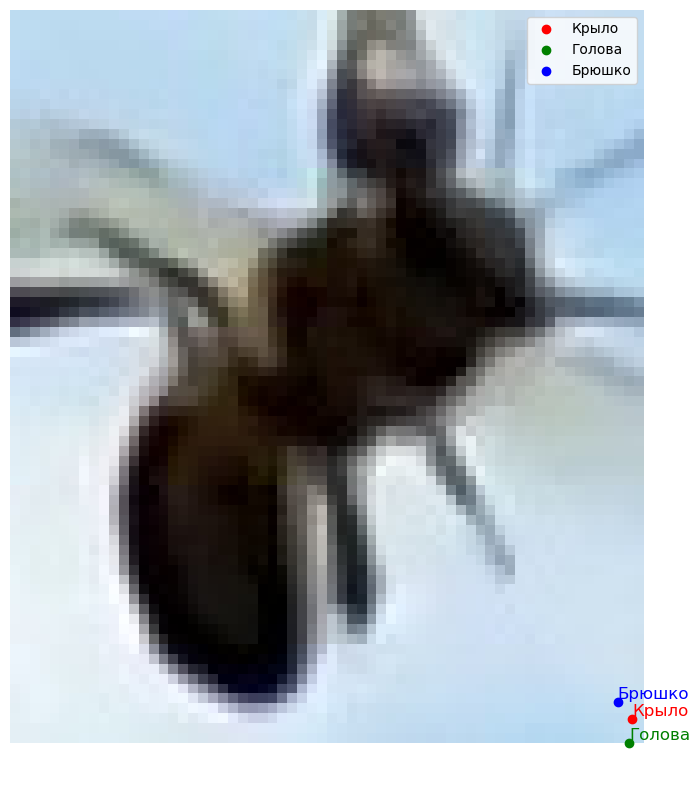

In [2]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def predict_bee_parts(image_path, model):
    # Загрузка и предобработка изображения
    img = Image.open(image_path).convert('RGB')
    original_size = img.size  # Сохраняем оригинальный размер для масштабирования
    img = img.resize((224, 224))  # Приведение к размеру модели
    img_array = np.array(img) / 255.0  # Нормализация
    print("Минимум и максимум значений в img_array:", img_array.min(), img_array.max())


    # Добавление размерности batch
    img_array = np.expand_dims(img_array, axis=0)

    # Предсказание
    predictions = model.predict(img_array)
    print("Сырые предсказания модели:", predictions)

    # Разделение предсказаний по частям тела
    wing = predictions[0][:3]  # [x, y, visibility]
    head = predictions[0][3:6]  # [x, y, visibility]
    abdomen = predictions[0][6:]  # [x, y, visibility]

    print(f"Крылья (нормализованные): {wing}")
    print(f"Голова (нормализованные): {head}")
    print(f"Брюшко (нормализованные): {abdomen}")

    # Масштабируем координаты в пиксели
    wing[0] *= original_size[0]  # x для крыла
    wing[1] *= original_size[1]  # y для крыла
    head[0] *= original_size[0]  # x для головы
    head[1] *= original_size[1]  # y для головы
    abdomen[0] *= original_size[0]  # x для брюшка
    abdomen[1] *= original_size[1]  # y для брюшка

    print(f"Крылья (в пикселях): {[wing[0], wing[1], wing[2]]}")
    print(f"Голова (в пикселях): {[head[0], head[1], head[2]]}")
    print(f"Брюшко (в пикселях): {[abdomen[0], abdomen[1], abdomen[2]]}")

    return wing, head, abdomen, original_size

def draw_predictions(image_path, model):
    wing, head, abdomen, original_size = predict_bee_parts(image_path, model)
    
    # Открываем изображение
    img = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    
    # Рисуем точки
    plt.plot(wing[0], wing[1], 'ro', label='Крыло')
    plt.plot(head[0], head[1], 'go', label='Голова')
    plt.plot(abdomen[0], abdomen[1], 'bo', label='Брюшко')
    
    # Добавляем подписи
    plt.text(wing[0], wing[1], 'Крыло', color='red', fontsize=12, verticalalignment='bottom')
    plt.text(head[0], head[1], 'Голова', color='green', fontsize=12, verticalalignment='bottom')
    plt.text(abdomen[0], abdomen[1], 'Брюшко', color='blue', fontsize=12, verticalalignment='bottom')
    
    plt.legend()
    plt.axis('off')
    plt.show()

# Пример использования
image_path = r"C:\Users\prol-\Documents\Masters\Thesis\dataset\bee_00874.jpg"
model = load_model('bee_parts_detection_model_new.keras')  # Убедитесь, что модель загружена
draw_predictions(image_path, model)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - loss: 0.1782 - mae: 0.3275 - val_loss: 0.1117 - val_mae: 0.2338
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.1738 - mae: 0.3013 - val_loss: 0.2119 - val_mae: 0.3584
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.2057 - mae: 0.3554 - val_loss: 0.1748 - val_mae: 0.3225
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.1969 - mae: 0.3677 - val_loss: 0.1780 - val_mae: 0.3429
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - loss: 0.1805 - mae: 0.3589 - val_loss: 0.1781 - val_mae: 0.3503
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - loss: 0.1736 - mae: 0.3537 - val_loss: 0.1960 - val_mae: 0.3471
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.1736 - mae: 0.3488 - val_loss: 0.1757 - val_mae: 0.3432
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - loss: 0.1764 - mae: 0.3481 - val_loss: 0.1882 - val_mae: 0.3501
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - loss: 0.1777 - mae: 

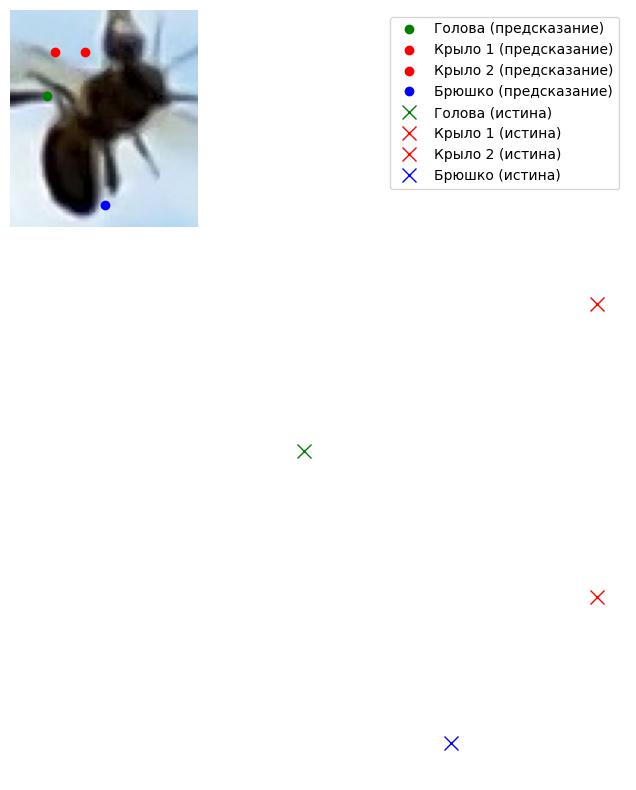

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt

# Загрузка предобученной модели ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Добавление слоев для регрессии координат
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(9, activation='sigmoid')(x)  # 3 точки * 3 значения (x, y, visibility)

model = Model(inputs=base_model.input, outputs=outputs)

# Заморозка слоев ResNet50 для начального обучения
for layer in base_model.layers:
    layer.trainable = False

# Кастомная функция потерь с весами
def custom_loss(y_true, y_pred):
    weights = tf.constant([2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=tf.float32)
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

# Компиляция модели с кастомной функцией потерь
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=custom_loss,
              metrics=['mae'])

# Функция загрузки данных из COCO-аннотаций
def load_data(coco_file_path, image_dir):
    with open(coco_file_path, 'r') as f:
        coco_data = json.load(f)

    def generator():
        for image_info in coco_data['images']:
            image_id = image_info['id']
            image_path = os.path.join(image_dir, image_info['file_name'])
            
            if os.path.exists(image_path):
                img = Image.open(image_path).convert('RGB')
                img = ImageOps.pad(img, (224, 224), method=Image.Resampling.BILINEAR)
                img_array = np.array(img) / 255.0

                annotations = next(
                    (ann for ann in coco_data['annotations'] if ann['image_id'] == image_id), 
                    None
                )

                keypoints = []
                if annotations:
                    for i in range(3):
                        x = annotations['keypoints'][i*3] / image_info['width']
                        y = annotations['keypoints'][i*3 + 1] / image_info['height']
                        visibility = annotations['keypoints'][i*3 + 2]
                        keypoints.extend([x, y, visibility])
                else:
                    keypoints = [0, 0, 0] * 3

                yield img_array, np.array(keypoints, dtype=np.float32)

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(9,), dtype=tf.float32)
        )
    )


# Пути к файлам
coco_file_path = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\merged_new.json"
image_dir = r'C:\Users\prol-\Documents\Masters\Thesis\analysis\imgs'

# Аугментация данных
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Генератор данных с аугментацией
def augmented_data_generator(coco_file_path, image_dir, batch_size=32):
    dataset = load_data(coco_file_path, image_dir)
    for images, keypoints in dataset.batch(batch_size).repeat():
        augmented_images = []
        augmented_keypoints = []
        for img, kp in zip(images, keypoints):
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = datagen.random_transform(img)
            augmented_images.append(img)
            augmented_keypoints.append(kp)
        yield np.array(augmented_images), np.array(augmented_keypoints)

# Создание аугментированных датасетов
train_dataset = augmented_data_generator(coco_file_path, image_dir, batch_size=32)
val_dataset = augmented_data_generator(coco_file_path, image_dir, batch_size=32)

# Обучение модели с аугментацией
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Начальное обучение
    steps_per_epoch=10,
    validation_steps=5
)

# Разморозка слоев и fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001),  # Уменьшите learning rate
              loss=custom_loss,
              metrics=['mae'])

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  # Fine-tuning
    steps_per_epoch=10,
    validation_steps=5
)

# Сохранение модели
model.save('bee_parts_detection_model_fixed.keras')

# Функция для предсказания и визуализации
def predict_bee_parts(image_path, model):
    img = Image.open(image_path).convert('RGB')
    original_size = img.size

    img = ImageOps.pad(img, (224, 224), method=Image.Resampling.BILINEAR)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)[0]  

    print(f"Predictions shape: {predictions.shape}")  # Отладка
    print(f"Predictions: {predictions}")  # Отладка

    if len(predictions) != 9:
        raise ValueError(f"Ошибка! Модель вернула {len(predictions)} значений вместо 9.")

    # Распределяем предсказания по частям тела
    head = predictions[:3]        # Голова (x, y, visibility)
    wing1 = predictions[3:6]      # Крыло 1 (x, y, visibility)
    wing2 = predictions[6:9]      # Крыло 2 (x, y, visibility)

    def rescale(point):
        if len(point) < 2:  # Дополнительная проверка
            raise ValueError(f"Ошибка! Недостаточно координат: {point}")
        return [int(point[0] * original_size[0]), int(point[1] * original_size[1])]

    head = rescale(head)
    wing1 = rescale(wing1)
    wing2 = rescale(wing2)

    # Брюшко — можно также добавить как фиксированную точку, если нужно
    abdomen = [int(0.5 * original_size[0]), int(0.9 * original_size[1])]  # Примерная фиксация брюшка внизу

    return head, wing1, wing2, abdomen, original_size

# Визуализация ошибок
def visualize_errors(image_path, model):
    head, wing1, wing2, abdomen, original_size = predict_bee_parts(image_path, model)
    
    img = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    # Рисуем предсказанные точки
    plt.plot(head[0], head[1], 'go', label='Голова (предсказание)')
    plt.plot(wing1[0], wing1[1], 'ro', label='Крыло 1 (предсказание)')
    plt.plot(wing2[0], wing2[1], 'ro', label='Крыло 2 (предсказание)')
    plt.plot(abdomen[0], abdomen[1], 'bo', label='Брюшко (предсказание)')

    # Рисуем истинные точки (если есть)
    # Замените true_head, true_wing1, true_wing2, true_abdomen на реальные значения
    true_head = [100, 150]  # Пример
    true_wing1 = [200, 100]
    true_wing2 = [200, 200]
    true_abdomen = [150, 250]

    plt.plot(true_head[0], true_head[1], 'gx', label='Голова (истина)', markersize=10)
    plt.plot(true_wing1[0], true_wing1[1], 'rx', label='Крыло 1 (истина)', markersize=10)
    plt.plot(true_wing2[0], true_wing2[1], 'rx', label='Крыло 2 (истина)', markersize=10)
    plt.plot(true_abdomen[0], true_abdomen[1], 'bx', label='Брюшко (истина)', markersize=10)

    plt.legend()
    plt.axis('off')
    plt.show()

# Использование
image_path = r"C:\Users\prol-\Documents\Masters\Thesis\dataset\bee_00874.jpg"
model = tf.keras.models.load_model('bee_parts_detection_model_fixed.keras', custom_objects={'custom_loss': custom_loss})
visualize_errors(image_path, model)

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt

# Загрузка предобученной модели ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Добавление слоев для регрессии координат
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(12, activation='sigmoid')(x)  # 4 точки * 3 значения (x, y, visibility)

model = Model(inputs=base_model.input, outputs=outputs)

# Заморозка слоев ResNet50 для начального обучения
for layer in base_model.layers:
    layer.trainable = False

# Кастомная функция потерь с весами
def custom_loss(y_true, y_pred):
    weights = tf.constant([2.0, 2.0, 1.0] * 4, dtype=tf.float32)  # 4 точки × 3 значения
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

# Компиляция модели с кастомной функцией потерь
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=custom_loss,
              metrics=['mae'])

# Функция загрузки данных из COCO-аннотаций
def load_data(coco_file_path, image_dir):
    with open(coco_file_path, 'r') as f:
        coco_data = json.load(f)

    def generator():
        for image_info in coco_data['images']:
            image_id = image_info['id']
            image_path = os.path.join(image_dir, image_info['file_name'])
            
            if os.path.exists(image_path):
                img = Image.open(image_path).convert('RGB')
                img = ImageOps.pad(img, (224, 224), method=Image.Resampling.BILINEAR)
                img_array = np.array(img) / 255.0

                annotation = next(
                    (ann for ann in coco_data['annotations'] if ann['image_id'] == image_id), 
                    None
                )

                if annotation:
                    # Порядок в аннотациях: брюшко, голова, крыло2, крыло1
                    keypoints = annotation['keypoints']
                    width = image_info['width']
                    height = image_info['height']
                    
                    # Преобразуем в порядок для модели: голова, брюшко, крыло1, крыло2
                    abdomen = [keypoints[0]/width, keypoints[1]/height, keypoints[2]]
                    head = [keypoints[3]/width, keypoints[4]/height, keypoints[5]]
                    wing2 = [keypoints[6]/width, keypoints[7]/height, keypoints[8]]
                    wing1 = [keypoints[9]/width, keypoints[10]/height, keypoints[11]]
                    
                    # Формируем массив в нужном порядке для модели
                    ordered_keypoints = np.array([
                        *head, *abdomen, *wing1, *wing2
                    ], dtype=np.float32)
                else:
                    ordered_keypoints = np.zeros(12, dtype=np.float32)

                yield img_array, ordered_keypoints

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(12,), dtype=tf.float32)
        )
    )

# Пути к файлам
coco_file_path = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\merged_new.json"
image_dir = r'C:\Users\prol-\Documents\Masters\Thesis\analysis\imgs'

# Аугментация данных
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Генератор данных с аугментацией
def augmented_data_generator(coco_file_path, image_dir, batch_size=32):
    dataset = load_data(coco_file_path, image_dir)
    for images, keypoints in dataset.batch(batch_size).repeat():
        augmented_images = []
        augmented_keypoints = []
        for img, kp in zip(images, keypoints):
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = datagen.random_transform(img)
            augmented_images.append(img)
            augmented_keypoints.append(kp)
        yield np.array(augmented_images), np.array(augmented_keypoints)

# Создание аугментированных датасетов
train_dataset = augmented_data_generator(coco_file_path, image_dir, batch_size=32)
val_dataset = augmented_data_generator(coco_file_path, image_dir, batch_size=32)

# Обучение модели с аугментацией
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Начальное обучение
    steps_per_epoch=10,
    validation_steps=5
)

# Разморозка слоев и fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001),  # Уменьшите learning rate
              loss=custom_loss,
              metrics=['mae'])

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  # Fine-tuning
    steps_per_epoch=10,
    validation_steps=5
)

# Сохранение модели
model.save('bee_parts_detection_model_fixed.keras')

# Функция для загрузки аннотаций из COCO файла
def load_annotations(coco_file_path):
    with open(coco_file_path, 'r') as f:
        coco_data = json.load(f)
    return coco_data

# Функция для получения истинных ключевых точек
def get_true_keypoints(coco_data, image_path):
    file_name = os.path.basename(image_path)
    image_info = next((img for img in coco_data['images'] if img['file_name'] == file_name), None)
    if not image_info:
        return None
    
    annotation = next((ann for ann in coco_data['annotations'] if ann['image_id'] == image_info['id']), None)
    if not annotation:
        return None
    
    keypoints = annotation['keypoints']
    width = image_info['width']
    height = image_info['height']
    
    # Порядок в аннотациях: брюшко, голова, крыло2, крыло1
    abdomen = [keypoints[0]/width, keypoints[1]/height, keypoints[2]]
    head = [keypoints[3]/width, keypoints[4]/height, keypoints[5]]
    wing2 = [keypoints[6]/width, keypoints[7]/height, keypoints[8]]
    wing1 = [keypoints[9]/width, keypoints[10]/height, keypoints[11]]
    
    return abdomen, head, wing2, wing1, width, height

# Функция для предсказания и визуализации
def predict_bee_parts(image_path, model):
    img = Image.open(image_path).convert('RGB')
    original_size = img.size

    img = ImageOps.pad(img, (224, 224), method=Image.Resampling.BILINEAR)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)[0]  # Получаем 12 значений в порядке: голова, брюшко, крыло1, крыло2

    # Преобразуем в физические координаты
    points = []
    for i in range(0, 12, 3):
        x = int(predictions[i] * original_size[0])
        y = int(predictions[i+1] * original_size[1])
        v = predictions[i+2]
        points.append([x, y, v])
    
    return points  # [голова, брюшко, крыло1, крыло2]

# Визуализация ошибок
def visualize_errors(image_path, model, coco_file_path):
    # Загружаем аннотации
    coco_data = load_annotations(coco_file_path)
    
    # Получаем истинные ключевые точки в порядке: брюшко, голова, крыло2, крыло1
    true_abdomen, true_head, true_wing2, true_wing1, width, height = get_true_keypoints(coco_data, image_path)
    if not true_abdomen:
        print(f"Не найдены аннотации для изображения {image_path}")
        return
    
    # Получаем предсказания в порядке: голова, брюшко, крыло1, крыло2
    predicted_head, predicted_abdomen, predicted_wing1, predicted_wing2 = predict_bee_parts(image_path, model)

    img = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    # Цвета для разных частей тела
    colors = {
        'head': 'green',
        'abdomen': 'blue',
        'wing': 'red'
    }

    # Рисуем предсказанные точки
    plt.plot(predicted_head[0], predicted_head[1], 'o', color=colors['head'], label='Голова (предсказание)')
    plt.plot(predicted_abdomen[0], predicted_abdomen[1], 'o', color=colors['abdomen'], label='Брюшко (предсказание)')
    plt.plot(predicted_wing1[0], predicted_wing1[1], 'o', color=colors['wing'], label='Крыло 1 (предсказание)')
    plt.plot(predicted_wing2[0], predicted_wing2[1], 'o', color=colors['wing'], label='Крыло 2 (предсказание)')

    # Рисуем истинные точки
    if true_head[2] > 0:  # Проверяем visibility
        plt.plot(true_head[0] * width, true_head[1] * height, 'x', color=colors['head'], markersize=10, label='Голова (истинная)')
    if true_abdomen[2] > 0:
        plt.plot(true_abdomen[0] * width, true_abdomen[1] * height, 'x', color=colors['abdomen'], markersize=10, label='Брюшко (истинное)')
    if true_wing1[2] > 0:
        plt.plot(true_wing1[0] * width, true_wing1[1] * height, 'x', color=colors['wing'], markersize=10, label='Крыло 1 (истинное)')
    if true_wing2[2] > 0:
        plt.plot(true_wing2[0] * width, true_wing2[1] * height, 'x', color=colors['wing'], markersize=10, label='Крыло 2 (истинное)')

    plt.legend()
    plt.axis('off')
    plt.show()

# Использование
image_path = r"C:\Users\prol-\Documents\Masters\Thesis\dataset\bee_00874.jpg"
model = tf.keras.models.load_model('bee_parts_detection_model_fixed.keras', custom_objects={'custom_loss': custom_loss})
visualize_errors(image_path, model, coco_file_path)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - loss: 0.2757 - mae: 0.3757 - val_loss: 0.1762 - val_mae: 0.2825
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 0.2255 - mae: 0.3285 - val_loss: 0.2399 - val_mae: 0.3560
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - loss: 0.2469 - mae: 0.3543 - val_loss: 0.2392 - val_mae: 0.3185
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - loss: 0.2348 - mae: 0.3585 - val_loss: 0.2360 - val_mae: 0.3391
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - loss: 0.2207 - mae: 0.3573 - val_loss: 0.2223 - val_mae: 0.3486
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 0.2193 - mae: 0.3594 - val_loss: 0.2492 - val_mae: 0.3426
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 0.2217 - mae: 0.3554 - val_loss: 0.2245 - val_mae: 0.3440
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - loss: 0.2294 - mae: 0.3555 - val_loss: 0.2338 - val_mae: 0.3412
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - loss: 0.2329 - mae: 

TypeError: cannot unpack non-iterable NoneType object

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


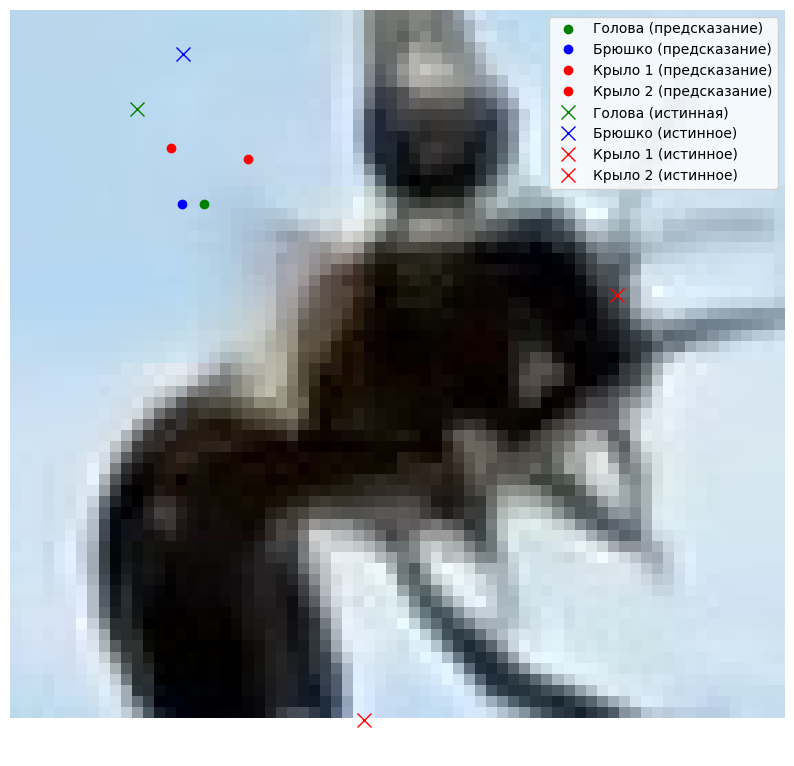

In [19]:
# Использование
image_path = r"C:\Users\prol-\Documents\Masters\Thesis\dataset\bee_00768.jpg"
visualize_errors(image_path, model, coco_file_path)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 197s 11s/step - loss: 0.1196 - mae: 0.2079 - val_loss: 0.1102 - val_mae: 0.2221
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 104s 10s/step - loss: 0.0256 - mae: 0.0540 - val_loss: 0.0900 - val_mae: 0.1839
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 95s 10s/step - loss: 0.0145 - mae: 0.0435 - val_loss: 0.0875 - val_mae: 0.1881
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 111s 11s/step - loss: 0.0113 - mae: 0.0367 - val_loss: 0.0576 - val_mae: 0.1323
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 95s 9s/step - loss: 0.0085 - mae: 0.0340 - val_loss: 0.0421 - val_mae: 0.1103
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 103s 10s/step - loss: 0.0077 - mae: 0.0313 - val_loss: 0.0462 - val_mae: 0.1084
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 97s 10s/step - loss: 0.0055 - mae: 0.0282 - val_loss: 0.0569 - val_mae: 0.1000
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 103s 10s/step - loss: 0.0064 - mae: 0.0295 - val_loss: 0.0532 - val_mae: 0.1035
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 104s 10s/step - loss: 

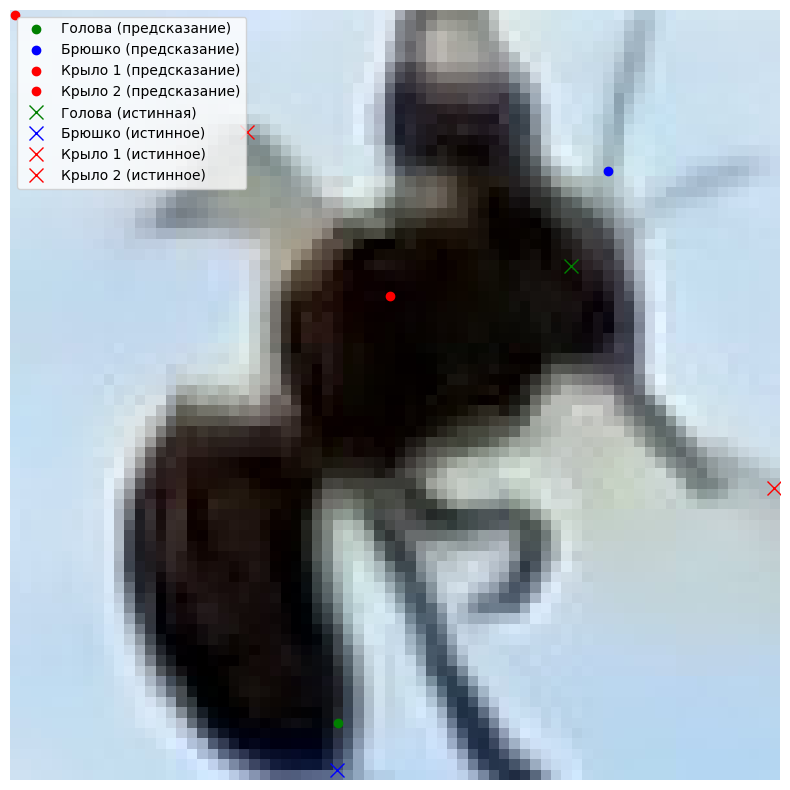

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import xml.etree.ElementTree as ET
from collections import defaultdict
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt

# 1. Парсинг CVAT XML аннотаций
def parse_cvat_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    annotations = []
    for image in root.findall('image'):
        img_data = {
            'name': image.get('name'),
            'width': float(image.get('width')),
            'height': float(image.get('height')),
            'points': defaultdict(list)
        }
        
        for points in image.findall('points'):
            label = points.get('label')
            points_str = points.get('points').split(';')
            occluded = points.get('occluded', '0') == '1'
            
            for i, point_str in enumerate(points_str):
                x, y = map(float, point_str.split(','))
                
                if label == 'wings':
                    point_name = f'wing_{i+1}'
                else:
                    point_name = label
                
                img_data['points'][point_name].append({
                    'x': x,
                    'y': y,
                    'v': 0 if occluded else 1  # 1 = visible, 0 = occluded
                })
        
        annotations.append(img_data)
    
    return annotations

# 2. Загрузка данных
def load_data(xml_path, image_dir):
    annotations = parse_cvat_xml(xml_path)
    
    def generator():
        for ann in annotations:
            image_path = os.path.join(image_dir, ann['name'])
            
            if os.path.exists(image_path):
                # Загрузка и предобработка изображения
                img = Image.open(image_path).convert('RGB')
                img = ImageOps.pad(img, (224, 224), method=Image.Resampling.BILINEAR)
                img_array = np.array(img) / 255.0
                
                # Инициализация ключевых точек (12 значений)
                keypoints = np.zeros(12, dtype=np.float32)
                
                # Заполнение точек (порядок: брюшко, голова, крыло1, крыло2)
                # abdomen (0-2)
                if 'abdomen' in ann['points'] and ann['points']['abdomen']:
                    a = ann['points']['abdomen'][0]
                    keypoints[0:3] = [a['x']/ann['width'], a['y']/ann['height'], a['v']]
                
                # head (3-5)
                if 'head' in ann['points'] and ann['points']['head']:
                    h = ann['points']['head'][0]
                    keypoints[3:6] = [h['x']/ann['width'], h['y']/ann['height'], h['v']]
                
                # wings (6-11)
                for i, wing in enumerate(['wing_1', 'wing_2']):
                    if wing in ann['points'] and i < len(ann['points'][wing]):
                        w = ann['points'][wing][i]
                        idx = 6 + i*3
                        keypoints[idx:idx+3] = [w['x']/ann['width'], w['y']/ann['height'], w['v']]
                
                yield img_array, keypoints

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(12,), dtype=tf.float32)
        )
    )

# 3. Инициализация модели
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(12, activation='sigmoid')(x)  # 4 точки * 3 значения
model = Model(inputs=base_model.input, outputs=outputs)

# 4. Функция потерь
def custom_loss(y_true, y_pred):
    weights = tf.constant([2.0, 2.0, 1.0] * 4, dtype=tf.float32)  # Веса для x,y,visibility
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

# 5. Аугментация данных
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augmented_data_generator(xml_path, image_dir, batch_size=32):
    dataset = load_data(xml_path, image_dir)
    for images, keypoints in dataset.batch(batch_size).repeat():
        augmented_images = []
        augmented_keypoints = []
        for img, kp in zip(images, keypoints):
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = datagen.random_transform(img)
            augmented_images.append(img)
            augmented_keypoints.append(kp)
        yield np.array(augmented_images), np.array(augmented_keypoints)

# 6. Функции для предсказания и визуализации
def predict_bee_parts(image_path, model):
    img = Image.open(image_path).convert('RGB')
    original_size = img.size

    img = ImageOps.pad(img, (224, 224), method=Image.Resampling.BILINEAR)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)[0]
    
    # Преобразуем в физические координаты (порядок: голова, брюшко, крыло1, крыло2)
    points = []
    for i in range(0, 12, 3):
        x = int(predictions[i] * original_size[0])
        y = int(predictions[i+1] * original_size[1])
        v = predictions[i+2]
        points.append([x, y, v])
    
    return points

def get_true_keypoints(xml_path, image_name):
    annotations = parse_cvat_xml(xml_path)
    for ann in annotations:
        if ann['name'] == image_name:
            width = ann['width']
            height = ann['height']
            
            # Получаем точки в порядке: брюшко, голова, крыло2, крыло1
            abdomen = head = wing1 = wing2 = [0, 0, 0]
            
            if 'abdomen' in ann['points'] and ann['points']['abdomen']:
                a = ann['points']['abdomen'][0]
                abdomen = [a['x'], a['y'], a['v']]
            
            if 'head' in ann['points'] and ann['points']['head']:
                h = ann['points']['head'][0]
                head = [h['x'], h['y'], h['v']]
            
            if 'wing_1' in ann['points'] and ann['points']['wing_1']:
                w1 = ann['points']['wing_1'][0]
                wing1 = [w1['x'], w1['y'], w1['v']]
            
            if 'wing_2' in ann['points'] and ann['points']['wing_2']:
                w2 = ann['points']['wing_2'][0]
                wing2 = [w2['x'], w2['y'], w2['v']]
            
            return abdomen, head, wing2, wing1, width, height
    
    return None

def visualize_errors(image_path, model, xml_path):
    image_name = os.path.basename(image_path)
    true_abdomen, true_head, true_wing2, true_wing1, width, height = get_true_keypoints(xml_path, image_name)
    
    # Получаем предсказания (голова, брюшко, крыло1, крыло2)
    pred_head, pred_abdomen, pred_wing1, pred_wing2 = predict_bee_parts(image_path, model)

    img = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    # Цвета для визуализации
    colors = {
        'head': 'green',
        'abdomen': 'blue',
        'wing': 'red'
    }

    # Предсказанные точки
    plt.plot(pred_head[0], pred_head[1], 'o', color=colors['head'], label='Голова (предсказание)')
    plt.plot(pred_abdomen[0], pred_abdomen[1], 'o', color=colors['abdomen'], label='Брюшко (предсказание)')
    plt.plot(pred_wing1[0], pred_wing1[1], 'o', color=colors['wing'], label='Крыло 1 (предсказание)')
    plt.plot(pred_wing2[0], pred_wing2[1], 'o', color=colors['wing'], label='Крыло 2 (предсказание)')

    # Истинные точки
    if true_head[2] > 0:
        plt.plot(true_head[0], true_head[1], 'x', color=colors['head'], markersize=10, label='Голова (истинная)')
    if true_abdomen[2] > 0:
        plt.plot(true_abdomen[0], true_abdomen[1], 'x', color=colors['abdomen'], markersize=10, label='Брюшко (истинное)')
    if true_wing1[2] > 0:
        plt.plot(true_wing1[0], true_wing1[1], 'x', color=colors['wing'], markersize=10, label='Крыло 1 (истинное)')
    if true_wing2[2] > 0:
        plt.plot(true_wing2[0], true_wing2[1], 'x', color=colors['wing'], markersize=10, label='Крыло 2 (истинное)')

    plt.legend()
    plt.axis('off')
    plt.show()

# 7. Обучение модели
xml_path = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations.xml"
image_dir = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\imgs"

# Загрузка данных
train_dataset = augmented_data_generator(xml_path, image_dir, batch_size=32)
val_dataset = augmented_data_generator(xml_path, image_dir, batch_size=32)

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=custom_loss,
              metrics=['mae'])

# Обучение
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=10,
    validation_steps=5
)

# Fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss=custom_loss,
              metrics=['mae'])

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=10,
    validation_steps=5
)

# Сохранение модели
model.save('bee_parts_detection_model_cvat.keras')

# 8. Пример использования
image_path = r"C:\Users\prol-\Documents\Masters\Thesis\dataset\bee_00856.jpg"
model = tf.keras.models.load_model('bee_parts_detection_model_cvat.keras', custom_objects={'custom_loss': custom_loss})
visualize_errors(image_path, model, xml_path)

In [3]:
import xml.etree.ElementTree as ET
import os

def merge_xml_files(xml_paths, output_path):
    """
    Объединяет несколько CVAT XML файлов в один с уникальными ID аннотаций
    Args:
        xml_paths (list): Список путей к XML файлам для объединения
        output_path (str): Путь для сохранения объединенного файла
    Returns:
        str: Путь к объединенному файлу
    """
    # Проверка наличия файлов
    for path in xml_paths:
        if not os.path.exists(path):
            raise FileNotFoundError(f"XML файл не найден: {path}")

    try:
        # Создаем базовую структуру из первого файла
        base_tree = ET.parse(xml_paths[0])
        base_root = base_tree.getroot()
        
        # Удаляем все изображения из базового файла
        for image in base_root.findall('image'):
            base_root.remove(image)
        
        # Счетчик для уникальных ID
        annotation_id = 1
        image_id = 1
        
        # Собираем и объединяем данные
        for xml_path in xml_paths:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            for image in root.findall('image'):
                # Обновляем ID изображения
                image.set('id', str(image_id))
                image_id += 1
                
                # Обновляем ID аннотаций
                for ann in image.findall('*'):
                    if 'id' in ann.attrib:
                        ann.set('id', str(annotation_id))
                        annotation_id += 1
                
                # Добавляем изображение в базовый файл
                base_root.append(image)
        
        # Обновляем мета-информацию
        meta = base_root.find('meta')
        if meta is not None:
            job = meta.find('job')
            if job is not None:
                # Обновляем количество изображений
                size_elem = job.find('size')
                if size_elem is not None:
                    size_elem.text = str(image_id - 1)
                
                # Обновляем frame range
                start_frame = job.find('start_frame')
                if start_frame is not None:
                    start_frame.text = '0'
                stop_frame = job.find('stop_frame')
                if stop_frame is not None:
                    stop_frame.text = str(image_id - 2)
        
        # Сохраняем объединенный файл
        base_tree.write(output_path, encoding='utf-8', xml_declaration=True)
        print(f"Успешно объединено {len(xml_paths)} файлов в {output_path}")
        print(f"Всего изображений: {image_id-1}, аннотаций: {annotation_id-1}")
        return output_path

    except ET.ParseError as e:
        raise ValueError(f"Ошибка парсинга XML: {str(e)}")
    except Exception as e:
        raise RuntimeError(f"Ошибка при объединении файлов: {str(e)}")

# Пример использования
if __name__ == "__main__":
    # Укажите фактические пути к вашим файлам
    xml_files = [
        r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations_101.xml",
        r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations_24.xml",
        r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations.xml"
    ]
    
    try:
        merged_file = merge_xml_files(xml_files, "merged_annotations.xml")
        print(f"Результат сохранен в: {merged_file}")
    except Exception as e:
        print(f"Ошибка: {str(e)}")

Успешно объединено 3 файлов в merged_annotations.xml
Всего изображений: 326, аннотаций: 0
Результат сохранен в: merged_annotations.xml


Начало обучения на 326 изображениях
Шагов на эпоху: 10
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.1640 - mae: 0.3562
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0510 - mae: 0.1829
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0423 - mae: 0.1351
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0417 - mae: 0.1240
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0392 - mae: 0.1204
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - loss: 0.0377 - mae: 0.1179
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - loss: 0.0367 - mae: 0.1152
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0351 - mae: 0.1121
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0341 - mae: 0.1106
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - loss: 0.0335 - mae: 0.1094
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - loss: 0.0326 - mae: 0.1081
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - loss: 0.0319 - mae: 0

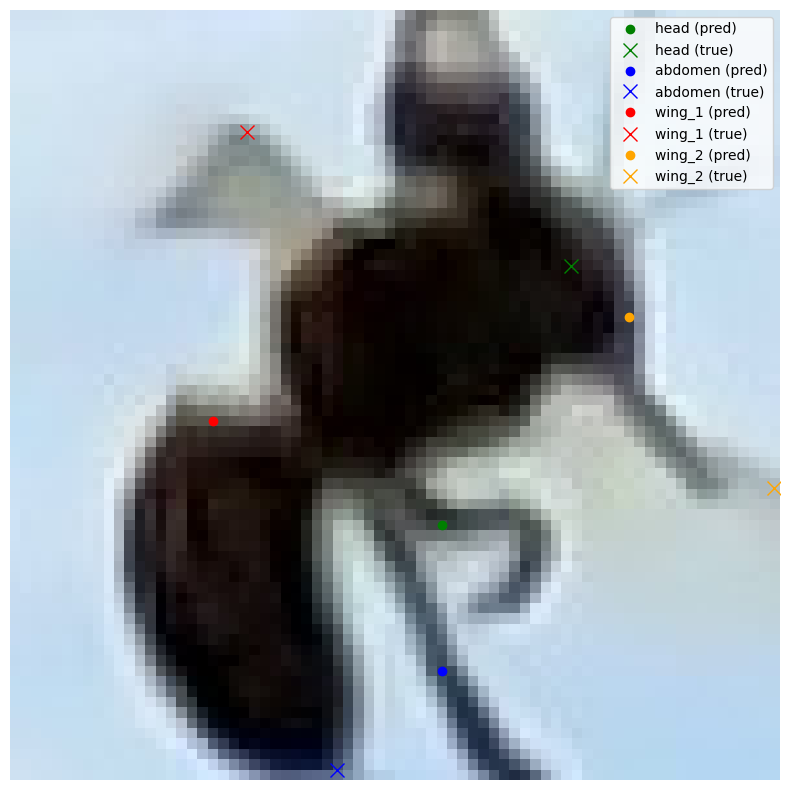

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt

def parse_cvat_xml(xml_path):
    """Парсинг CVAT XML с обработкой точек"""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    annotations = []
    for image in root.findall('image'):
        img_data = {
            'name': image.get('name'),
            'width': float(image.get('width')),
            'height': float(image.get('height')),
            'points': {'head': None, 'abdomen': None, 'wing_1': None, 'wing_2': None}
        }
        
        wing_count = 0
        for points in image.findall('points'):
            label = points.get('label')
            points_str = points.get('points').split(';')
            occluded = points.get('occluded', '0') == '1'
            
            for point_str in points_str[:2]:  # Только первые 2 точки для wings
                x, y = map(float, point_str.split(','))
                
                if label == 'wings':
                    wing_count += 1
                    if wing_count > 2:
                        continue
                    point_name = f'wing_{wing_count}'
                elif label in ['head', 'abdomen']:
                    point_name = label
                else:
                    continue
                
                img_data['points'][point_name] = {
                    'x': x, 'y': y, 'v': 0 if occluded else 1
                }
        
        annotations.append(img_data)
    return annotations

def create_dataset(xml_path, image_dir, batch_size=32):
    """Создает tf.data.Dataset с бесконечным повторением"""
    annotations = parse_cvat_xml(xml_path)
    
    def generator():
        while True:  # Бесконечный цикл для .repeat()
            for ann in annotations:
                image_path = os.path.join(image_dir, ann['name'])
                if not os.path.exists(image_path):
                    continue
                
                # Загрузка и обработка изображения
                img = Image.open(image_path).convert('RGB')
                img = ImageOps.pad(img, (224, 224), method=Image.Resampling.BILINEAR)
                img_array = np.array(img) / 255.0
                
                # Формирование ключевых точек
                keypoints = []
                for point_name in ['head', 'abdomen', 'wing_1', 'wing_2']:
                    point = ann['points'][point_name]
                    keypoints.extend([
                        point['x']/ann['width'] if point else 0,
                        point['y']/ann['height'] if point else 0,
                        point['v'] if point else 0
                    ])
                
                yield img_array, np.array(keypoints, dtype=np.float32)
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(12,), dtype=np.float32)
        )
    )
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

def create_model():
    """Создает модель на основе ResNet50 с правильной заморозкой слоев"""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Замораживаем все слои изначально
    base_model.trainable = False
    
    # Создаем новую модель
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(12, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    
    return model



def visualize_errors(image_path, model, xml_path):
    """Визуализация предсказаний и истинных точек"""
    annotations = parse_cvat_xml(xml_path)
    image_name = os.path.basename(image_path)
    ann = next((a for a in annotations if a['name'] == image_name), None)
    
    if not ann:
        print(f"Аннотации для {image_name} не найдены")
        return

    # Загрузка и предсказание
    img = Image.open(image_path).convert('RGB')
    original_size = img.size
    img_array = np.array(ImageOps.pad(img, (224, 224))) / 255.0
    pred = model.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]
    
    # Преобразование предсказаний
    predicted_points = {}
    point_names = ['head', 'abdomen', 'wing_1', 'wing_2']
    for i, name in enumerate(point_names):
        idx = i * 3
        predicted_points[name] = [
            int(pred[idx] * original_size[0]),
            int(pred[idx+1] * original_size[1]),
            pred[idx+2]
        ]
    
    # Визуализация
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    
    colors = {'head': 'green', 'abdomen': 'blue', 'wing_1': 'red', 'wing_2': 'orange'}
    
    # Рисуем точки
    for name in point_names:
        # Предсказанные точки
        if predicted_points[name][2] > 0.5:
            plt.plot(predicted_points[name][0], predicted_points[name][1], 
                    'o', color=colors[name], label=f'{name} (pred)')
        
        # Истинные точки
        point = ann['points'][name]
        if point and point['v']:
            plt.plot(point['x'], point['y'], 'x', 
                    color=colors[name], markersize=10, label=f'{name} (true)')
    
    plt.legend()
    plt.axis('off')
    plt.show()

def main():
    # Пути к данным
    xml_path = "merged_annotations.xml"
    image_dir = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\imgs"
    model_path = "bee_model.keras"
    
    # Создание модели
    model = create_model()
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    
    # Создание датасета
    train_dataset = create_dataset(xml_path, image_dir, batch_size=32)
    num_images = len(parse_cvat_xml(xml_path))
    steps_per_epoch = max(1, num_images // 32)
    
    print(f"Начало обучения на {num_images} изображениях")
    print(f"Шагов на эпоху: {steps_per_epoch}")
    
    # Обучение
    history = model.fit(
        train_dataset,
        epochs=20,
        steps_per_epoch=steps_per_epoch,
        verbose=1
    )
    
    # Fine-tuning (размораживаем все слои)
    model.layers[1].trainable = True  # Размораживаем ResNet
    
    # Важно: повторная компиляция после изменения trainable
    model.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss='mse',
        metrics=['mae']
    )
    
    # Продолжаем обучение
    model.fit(
        train_dataset,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        verbose=1
    )
    
    # Сохранение модели
    model.save(model_path)
    print(f"Модель сохранена в {model_path}")
    
    # Тестирование
    test_image = r"C:\Users\prol-\Documents\Masters\Thesis\dataset\bee_00856.jpg"
    if os.path.exists(test_image):
        visualize_errors(test_image, model, xml_path)
    else:
        print(f"Тестовое изображение не найдено: {test_image}")

if __name__ == "__main__":
    main()


Dataset sizes - Train: 140, Val: 20, Test: 41
Steps per epoch: 4, Validation steps: 1

Initial training with frozen layers...
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - loss: 0.0935 - mae: 0.2534 - val_loss: 0.0711 - val_mae: 0.2205 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - loss: 0.0251 - mae: 0.1041 - val_loss: 0.0411 - val_mae: 0.1654 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 0.0249 - mae: 0.0916 - val_loss: 0.0326 - val_mae: 0.1428 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - loss: 0.0235 - mae: 0.0922 - val_loss: 0.0287 - val_mae: 0.1283 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - loss: 0.0218 - mae: 0.0858 - val_loss: 0.0275 - val_mae: 0.1225 - learning_rate: 1.0000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - loss: 0.0185 - mae: 0.0793 - val_loss: 0.0273 - val_mae: 0.1209 - learning_rate: 1.0000e-04
Epoch 7/30
4/4 ━━━━━━

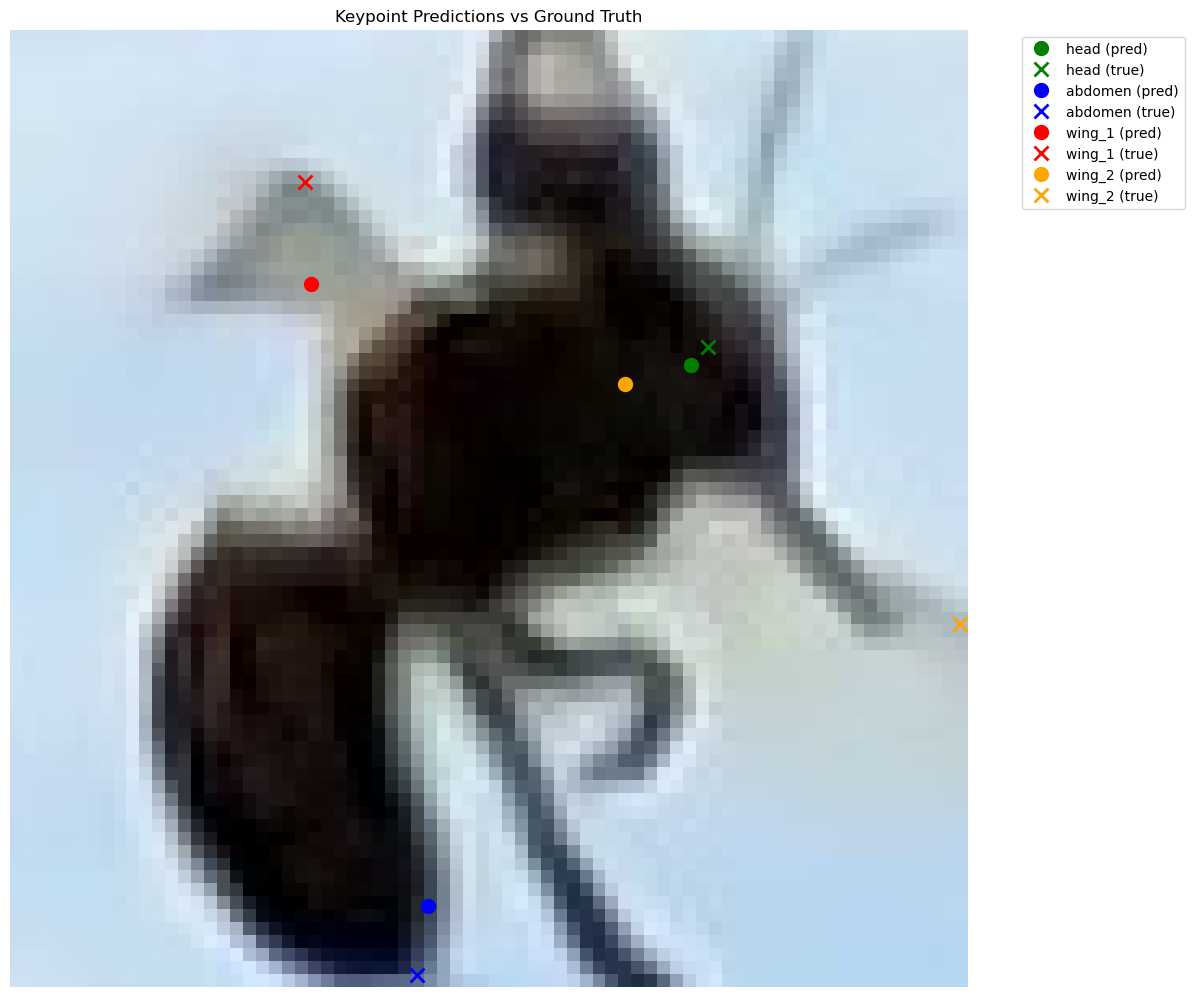

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def parse_cvat_xml(xml_path):
    """Parse CVAT XML annotations with keypoint handling"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        annotations = []
        for image in root.findall('image'):
            img_data = {
                'name': image.get('name'),
                'width': float(image.get('width')),
                'height': float(image.get('height')),
                'points': {'head': None, 'abdomen': None, 'wing_1': None, 'wing_2': None}
            }
            
            wing_count = 0
            for points in image.findall('points'):
                label = points.get('label')
                points_str = points.get('points').split(';')
                occluded = points.get('occluded', '0') == '1'
                
                for point_str in points_str[:2]:  # Only first 2 points for wings
                    x, y = map(float, point_str.split(','))
                    
                    if label == 'wings':
                        wing_count += 1
                        if wing_count > 2:
                            continue
                        point_name = f'wing_{wing_count}'
                    elif label in ['head', 'abdomen']:
                        point_name = label
                    else:
                        continue
                    
                    img_data['points'][point_name] = {
                        'x': x, 'y': y, 'v': 0 if occluded else 1
                    }
            
            annotations.append(img_data)
        return annotations
    except Exception as e:
        print(f"Error parsing XML: {e}")
        return []

def create_datasets(xml_path, image_dir, test_size=0.2, val_size=0.1, batch_size=32):
    """Create train, validation, and test datasets with proper splitting"""
    annotations = parse_cvat_xml(xml_path)
    if not annotations:
        raise ValueError("No annotations found or error parsing XML")
    
    # Filter out images that don't exist
    valid_annotations = []
    for ann in annotations:
        image_path = os.path.join(image_dir, ann['name'])
        if os.path.exists(image_path):
            valid_annotations.append(ann)
    
    if not valid_annotations:
        raise ValueError("No valid images found in the specified directory")
    
    # Split data into train, validation, and test sets
    train_val, test = train_test_split(valid_annotations, test_size=test_size, random_state=42)
    train, val = train_test_split(train_val, test_size=val_size/(1-test_size), random_state=42)
    
    def dataset_generator(data_split):
        for ann in data_split:
            try:
                image_path = os.path.join(image_dir, ann['name'])
                img = Image.open(image_path).convert('RGB')
                img = ImageOps.pad(img, (224, 224), method=Image.Resampling.BILINEAR)
                img_array = np.array(img) / 255.0
                
                keypoints = []
                for point_name in ['head', 'abdomen', 'wing_1', 'wing_2']:
                    point = ann['points'][point_name]
                    keypoints.extend([
                        point['x']/ann['width'] if point else 0,
                        point['y']/ann['height'] if point else 0,
                        point['v'] if point else 0
                    ])
                
                yield img_array, np.array(keypoints, dtype=np.float32)
            except Exception as e:
                print(f"Skipping image {ann['name']} due to error: {e}")
                continue
    
    # Create datasets for each split
    output_signature = (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(12,), dtype=np.float32)
    )
    
    # Use repeat() to avoid running out of data
    train_ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(train),
        output_signature=output_signature
    ).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    val_ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(val),
        output_signature=output_signature
    ).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    test_ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(test),
        output_signature=output_signature
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds, len(train), len(val), len(test)

def create_enhanced_model():
    """Create improved model with better architecture"""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze initial layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Create new model
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(12, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

def train_model(model, train_ds, val_ds, steps_per_epoch, validation_steps, epochs=30):
    """Train model with callbacks and learning rate scheduling"""
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]
    
    # Initial training with frozen layers
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='mse',
        metrics=['mae']
    )
    
    print("\nInitial training with frozen layers...")
    history = model.fit(
        train_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    # Fine-tuning with unfrozen layers
    for layer in model.layers[1].layers[-20:]:  # Unfreeze last 20 layers of ResNet
        layer.trainable = True
    
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='mse',
        metrics=['mae']
    )
    
    print("\nFine-tuning with unfrozen layers...")
    model.fit(
        train_ds,
        epochs=epochs//2,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    return model

def evaluate_model(model, test_ds):
    """Evaluate model on test set"""
    print("\nEvaluating on test set...")
    try:
        # Evaluate on all test data (don't specify steps)
        results = model.evaluate(test_ds, verbose=1)
        if isinstance(results, list) and len(results) >= 2:
            print(f"Test Loss: {results[0]:.4f}, Test MAE: {results[1]:.4f}")
        else:
            print("Unexpected evaluation results format:", results)
    except Exception as e:
        print(f"Error during evaluation: {e}")

def visualize_predictions(image_path, model, xml_path):
    """Visualize predictions vs ground truth"""
    annotations = parse_cvat_xml(xml_path)
    if not annotations:
        print("No annotations found")
        return
        
    image_name = os.path.basename(image_path)
    ann = next((a for a in annotations if a['name'] == image_name), None)
    
    if not ann:
        print(f"Annotations for {image_name} not found")
        return

    try:
        # Load and predict
        img = Image.open(image_path).convert('RGB')
        original_size = img.size
        img_array = np.array(ImageOps.pad(img, (224, 224))) / 255.0
        pred = model.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]
        
        # Process predictions
        predicted_points = {}
        point_names = ['head', 'abdomen', 'wing_1', 'wing_2']
        for i, name in enumerate(point_names):
            idx = i * 3
            predicted_points[name] = {
                'x': pred[idx] * original_size[0],
                'y': pred[idx+1] * original_size[1],
                'v': pred[idx+2] > 0.5  # Visibility threshold
            }
        
        # Visualization
        plt.figure(figsize=(12, 12))
        plt.imshow(img)
        
        colors = {'head': 'green', 'abdomen': 'blue', 'wing_1': 'red', 'wing_2': 'orange'}
        markers = {'pred': 'o', 'true': 'x'}
        
        # Plot points
        for name in point_names:
            # Predicted points
            if predicted_points[name]['v']:
                plt.plot(predicted_points[name]['x'], predicted_points[name]['y'], 
                        markers['pred'], color=colors[name], 
                        markersize=10, label=f'{name} (pred)')
            
            # True points
            point = ann['points'][name]
            if point and point['v']:
                plt.plot(point['x'], point['y'], markers['true'], 
                        color=colors[name], markersize=10, 
                        markeredgewidth=2, label=f'{name} (true)')
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title('Keypoint Predictions vs Ground Truth')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error visualizing predictions: {e}")

def main():
    try:
        # Path configuration
        xml_path = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\annotations\annotations.xml"
        image_dir = r"C:\Users\prol-\Documents\Masters\Thesis\analysis\imgs"
        model_path = "bee_model.keras"
        
        # Create datasets
        train_ds, val_ds, test_ds, train_size, val_size, test_size = create_datasets(xml_path, image_dir)
        
        # Calculate steps
        batch_size = 32
        steps_per_epoch = max(1, train_size // batch_size)
        val_steps = max(1, val_size // batch_size)
        
        print(f"\nDataset sizes - Train: {train_size}, Val: {val_size}, Test: {test_size}")
        print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {val_steps}")
        
        # Create and train model
        model = create_enhanced_model()
        model = train_model(model, train_ds, val_ds, steps_per_epoch, val_steps)
        
        # Evaluate and save
        evaluate_model(model, test_ds)
        model.save(model_path)
        print(f"Model saved to {model_path}")
        
        # Visualization example
        test_image = os.path.join(image_dir, "bee_00856.jpg")
        if os.path.exists(test_image):
            visualize_predictions(test_image, model, xml_path)
        else:
            print("\nTest image not found, using first available test image")
            for test_batch in test_ds.take(1):
                test_image_array = test_batch[0][0].numpy()
                plt.figure(figsize=(8, 8))
                plt.imshow(test_image_array)
                plt.title("Sample Test Image")
                plt.axis('off')
                plt.show()
                
    except Exception as e:
        print(f"\nError in main execution: {e}")

if __name__ == "__main__":
    main()